### Time Series Decomposition
##### Decomposition is basically applied in time series analysis, it can also be used as a tool to inform forecasting models on a problem

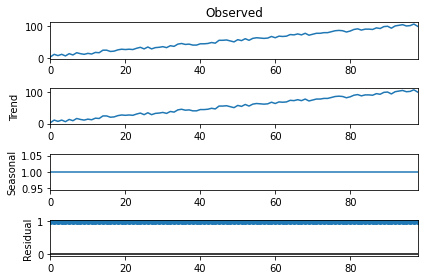

In [1]:
import numpy as np
import pandas as pd
from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
series = [i+randrange(10) for i in range(1,100)]
result = seasonal_decompose(series, model='multiplicative', period=1)
result.plot()
pyplot.show()

### Forecasting fewer outputs with Enc-Dec LSTM

The shape of the raw_data before scaling is (43800, 5)
Epoch 1/100
308/308 [==============================] - 21s 59ms/step - loss: 0.0184
Epoch 2/100
308/308 [==============================] - 18s 58ms/step - loss: 0.0121
Epoch 3/100
308/308 [==============================] - 18s 59ms/step - loss: 0.0111
Epoch 4/100
308/308 [==============================] - 18s 59ms/step - loss: 0.0111
Epoch 5/100
308/308 [==============================] - 18s 59ms/step - loss: 0.0106
Epoch 6/100
308/308 [==============================] - 18s 59ms/step - loss: 0.0110
Epoch 7/100
308/308 [==============================] - 19s 60ms/step - loss: 0.0108
Epoch 8/100
308/308 [==============================] - 19s 60ms/step - loss: 0.0113
Epoch 9/100
308/308 [==============================] - 18s 59ms/step - loss: 0.0114
Epoch 10/100
308/308 [==============================] - 18s 59ms/step - loss: 0.0110
Epoch 11/100
308/308 [==============================] - 18s 59ms/step - loss: 0.0117
Epoch 12/100
308/30

308/308 [==============================] - 18s 59ms/step - loss: 0.0091
Epoch 97/100
308/308 [==============================] - 18s 58ms/step - loss: 0.0090
Epoch 98/100
308/308 [==============================] - 18s 58ms/step - loss: 0.0091
Epoch 99/100
308/308 [==============================] - 18s 58ms/step - loss: 0.0090
Epoch 100/100
308/308 [==============================] - 18s 58ms/step - loss: 0.0089
Initial shape of x_input (50, 5)
The shape of yhat after prediction is (1, 100, 5)
The new shape of yhat  is (100, 5)
[[ 141.0517     -13.490174    -3.589036  1027.5009      44.858837 ]
 [ 140.90639    -12.7675495   -2.5452847 1025.4124      38.66219  ]
 [ 145.5001     -12.626293    -2.692147  1025.39        35.46577  ]
 [ 146.97899    -12.509077    -2.6693738 1025.2279      34.135883 ]
 [ 147.11537    -12.48558     -2.6973283 1025.2246      33.580128 ]
 [ 146.30031    -12.525147    -2.7534626 1025.3079      33.389275 ]
 [ 144.93059    -12.598452    -2.8207448 1025.4312      33.38

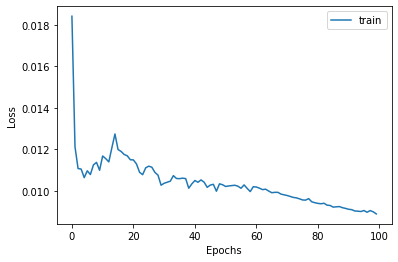

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11200     
                                                                 
 repeat_vector (RepeatVector  (None, 100, 50)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 time_distributed (TimeDistr  (None, 100, 5)           255       
 ibuted)                                                         
                                                                 
Total params: 31,655
Trainable params: 31,655
Non-trainable params: 0
_________________________________________________________________


In [6]:
# multivariate output stacked lstm example
import pandas as pd
from numpy import array
from numpy import hstack, vstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Bidirectional, RepeatVector, TimeDistributed
from keras.layers.core import Dropout
from sklearn.preprocessing import MinMaxScaler
from pandas import read_csv
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np



# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence

# Read the data
# data = read_csv('waterTank.csv', header=0, index_col=0)
# data = read_csv('outputs.csv', header=0, index_col=0)
# data = read_csv('trig.csv', header=0, index_col=0)
data = read_csv('pollution2.csv', header=0, index_col=0)

# horizontally stack columns
raw_data = data.values
print(f'The shape of the raw_data before scaling is {raw_data.shape}')
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(raw_data)

n_train = 10000
dataset = scaled_data[0:n_train,:]
# choose a number of time steps
# n_steps_in, n_steps_out = 50, 100
n_steps_in, n_steps_out = 50, 100

# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(50, activation='relu', return_sequences=True))
# model.add(TimeDistributed(Dense(50, activation='relu')))
model.add(TimeDistributed(Dense(n_features)))
# model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
# fit model
train_history = model.fit(X, y, epochs=100, verbose=1, shuffle=False)

# demonstrate Direct prediction
# x_inp = raw_data[n_train:n_train+n_steps,:]
x_inp = scaled_data[n_train:n_train+n_steps_in,:]
print(f'Initial shape of x_input {x_inp.shape}')
x_input = x_inp.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(f'The shape of yhat after prediction is {yhat.shape}')
yhat = yhat.reshape(n_steps_out, n_features)
print(f'The new shape of yhat  is {yhat.shape}')
inv_yhat = scaler.inverse_transform(yhat)
print(inv_yhat)

print("-------Learning Curve--------")
plt.plot(train_history.history['loss'], label='train')
# plt.plot(train_history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

model.summary()

In [2]:
len(inv_yhat.T)

4

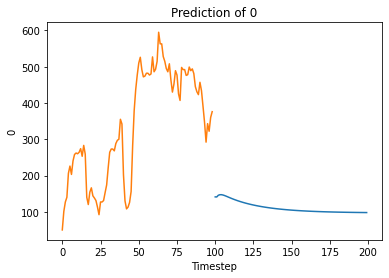

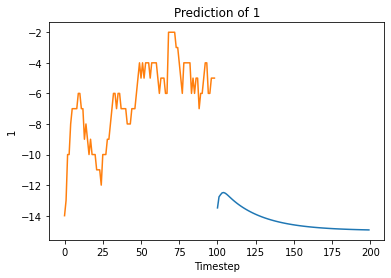

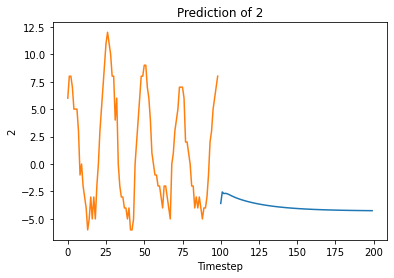

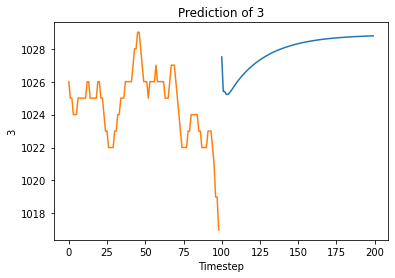

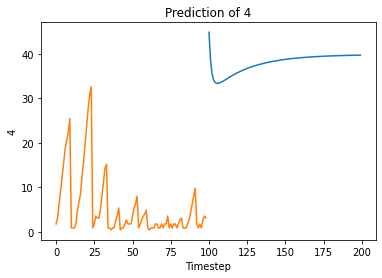

In [8]:
attr = len(inv_yhat.T)
for i in range(attr):
    title = "Prediction of "+str(i)
    actual = raw_data[9901:10000,i]
    pred = inv_yhat.T
    pred_df = pd.DataFrame(inv_yhat)
    # specify the range based on the length of predicted output
    index = pd.Index(list(range(100,200)))
    pred_df = pred_df.set_index(index)
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel(i)
#     plt.plot(pred[i], label="predicted")
#     plt.plot(actual, label="actual")
    plt.plot(pred_df[i])
    plt.plot(actual)
    plt.show()

In [1]:
print("Welcome , H.B Adeyemo")

Welcome , H.B Adeyemo


### Forecasting fewer outputs with Enc-Dec GRU

### Fault Injection

In [ ]:
## Fault Injection
from pandas import read_csv
from random import randint
# from random import random
import random
import math


def inject_Fault_Univariate(data):
    n = len(data)
    fault_units = [-30.5, -20.5, 0, 15.5, 25.5]
    for i in range(len(data)):
        p = random.random()
        if p > 0.5:
            data["column"].iloc[i] += random.choice(fault_units)
            
    return data

def inject_Fault_Multivariate(data):
    n = len(data)
    fault_units = [-30.5, -20.5, 0, 15.5, 25.5]
    for col in data.columns:
        
        for i in range(len(data)):
            p = random.random()
            if p > 0.5:
                data[col].iloc[i] += random.choice(fault_units)

    return data

def bit_flip(data, col, loc):
    if (len(data[col].unique())):
        for i in data[col]:
            data[col][i] = random.randint(0,1)
    return data

def insert_outlier(data, col):
#     // This inserts at the beginning of the data
    maxi = data.describe()[col]["max"]
    mini = data.describe()[col]["min"]
    outlier = (maxi - mini)*50
    n = math.floor(len(data)*0.2)
    for i in range(len(data[col][0:n])):
        data[col].iloc[i] += outlier    
    return data

def stuck_at(data, val, col, loc="beg"):
    # This is either stuck_at zero or at 1
    if(loc == "beg"):
        n = math.floor(len(data[col])*0.3)
        for i in range(n):
            data[col][i] = val
    return data



my_data = read_csv("waterTank.csv", header=0)
my_data = my_data.iloc[1:50,:]

# myNewdata = inject_Fault_Univariate(my_data)
myNewdata = inject_Fault_Multivariate(my_data)
myNewdata.to_csv("Randomized_data.csv")

flipped_data = bit_flip(my_data, "Tank1InFlow")
flipped_data.to_csv("flipped_data.csv")

outliered = insert_outlier(my_data, "Tank2WaterLevel")
outliered.to_csv("outlier_data.csv")

stuck_data = stuck_at(my_data, 1, "Tank1InFlow", loc="beg")
stuck_data.to_csv("stuck_at_one.csv")

print("Files saved successfully")

In [4]:
import pandas as pd
from numpy import array
from pandas import read_csv
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np

def bit_flip(data, loc, col = 0):
    if (len(data[col].unique())):
        for i in data[col][1:5]:
#             data[col][i] = random.randint(0,1)
            if(data[col][i] == 0):
                data[col][i] = 1
            else:
                data[col][i] = 0
                    
    return data

mydata = read_csv('simulated_waterTank.csv', header=0, index_col=0, skiprows=4)
newData = mydata.iloc[1:20, :1]
# newData

# newData.iloc[1:5,0] = 50
# newData.iloc[10:15,0] = 50
# newData
# myData = bit_flip(newData, 2, 1)
newData

,1
0.15,
0.25,0
0.30,0
0.35,1
0.40,1
0.45,0
0.50,0
0.55,1
0.60,1
0.65,0
